# Simulating Hierarchical Bayesian Reinforcement Learning


Simulated example to illustrate the success of the methodology.

The same as before, however now $10$ individuals have their parameters sampled the population distributions:

$\alpha^i \sim $
$$

----
```
author:    Zach Wolpe
email:     zachcolinwolpe@gmail.com
reviewer:  na
date:      11 January 2022
```
----

In [ ]:
# %%capture
# !pip upgrade arviz==0.6.1
# !pip install git+https://github.com/pymc-devs/pymc3
# !pip install git+git://github.com/arviz-devs/arviz.git


Mean Accuracy: 0.681 (0.042)


In [ ]:
import matplotlib.pyplot as plt
import theano.tensor as tt
from scipy import stats
from tqdm import tqdm
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import theano
import math

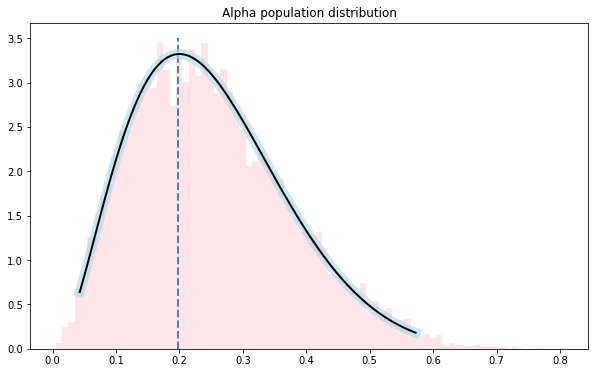

In [ ]:
# alpha population distribution ------------------------------*
# params
a,b = 3,9

# distribution
mean, var, skew, kurt = stats.beta.stats(a,b, moments='mvsk')
x = np.linspace(stats.beta.ppf(0.01, a, b),
                stats.beta.ppf(0.99, a, b), 100)
y = stats.beta.pdf(x, a, b)

# random sample
rv = stats.beta(a, b)
r  = rv.rvs(size=10000)

# vis 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'lightblue', lw=10, alpha=0.6, label='beta pdf')
ax.plot(x, y, 'k-', lw=2, label='frozen pdf')
ax.hist(r, bins=80, density=True, color='pink', histtype='stepfilled', alpha=0.4)
ax.vlines(x=x[np.where(y==max(y))], ymin=0, ymax=3.5, lw=2, color='steelblue', linestyles='dashed')
plt.title('Alpha population distribution')
plt.show()
# alpha population distribution ------------------------------*

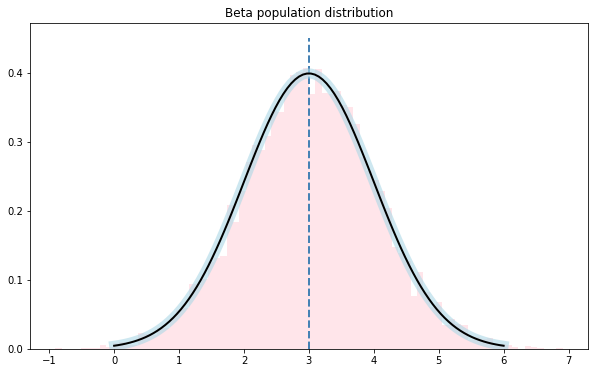

In [ ]:
# beta population distribution -------------------------------*
# params
mu        = 3
variance  = 1

# distribution
sigma = math.sqrt(variance)
x     = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y     = stats.norm.pdf(x, mu, sigma)

# random sample
rv = stats.norm(mu, sigma)
r  = rv.rvs(size=10000)

# vis 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'lightblue', lw=10, alpha=0.6, label='alpha pdf')
ax.plot(x, y, 'k-', lw=2, label='frozen pdf')
ax.hist(r, bins=80, density=True, color='pink', histtype='stepfilled', alpha=0.4)
ax.vlines(x=mu, ymin=0, ymax=0.45, lw=2, color='steelblue', linestyles='dashed')
plt.title('Beta population distribution')
plt.show()
# beta population distribution -------------------------------*

# Generate Subject Data

In [ ]:

%%time
# sample population distributions ------------------------------------------*
n_samples = 100
subject_betas  = stats.norm(loc=mu, scale=sigma).rvs(n_samples)
subject_alphas = stats.beta(a, b).rvs(n_samples)

CPU times: user 2.88 ms, sys: 0 ns, total: 2.88 ms
Wall time: 4.9 ms


In [ ]:
# DGP ----------------------------------------------------------------------*
def data_generating_process(alpha, beta, n=100, p_r=[.8, .6, .7]):
  actions = np.zeros(n, dtype=np.int)
  rewards = np.zeros(n, dtype=np.int)
  Qs      = np.zeros((n, 3))

  # Q init
  Q = np.array(len(p_r)*[1/len(p_r)])

  for i in tqdm(range(n)):
    # P(a|Q): Apply Boltzmann distribution
    exp_Q = np.exp(beta*Q)
    pi_a  = exp_Q / np.sum(exp_Q)


    # Simulate action-reward
    a = np.random.choice([0,1,2], p=pi_a)
    r = np.random.rand() < p_r[a]

    # Update Qt(a) = Qt-1(a) + a[RPE]
    Q[a] = Q[a] + alpha * (r - Q[a])

    # store
    actions[i] = a
    rewards[i] = r
    Qs[i] = Q.copy()

  return actions, rewards, Qs  

In [ ]:
# store as a dict
n = 100
data = {}
for i, theta in enumerate(zip(subject_alphas, subject_betas)):
  actions, rewards, Qs = data_generating_process(alpha=theta[0], beta=theta[1], n=n)
  data['subject_'+str(i)] = {'actions': actions, 'rewards':rewards, 'true_alpha':theta[0], 'true_beta':theta[1], 'Qs':Qs}

100%|██████████| 100/100 [00:00<00:00, 11701.22it/s]


# Method I: Summary Statistics

As a baseline point of comparison, one can use the niave method of fitting all subjects independently & then use thier estimates as samples from the population to estimate the population distribution. This is referred to as the summary statistics approach.

## Fit

Here we fit all $10$ models independently.

In [ ]:
%%time
# Bayes RL  ==================================================================================================================================*

# each subject
for i in tqdm(range(n_samples)):
  actions = data['subject_'+str(i)]['actions']
  rewards = data['subject_'+str(i)]['rewards']

  with pm.Model() as bayesian_reinforcement_learning:

    # data
    actions_  = pm.Data('actions', actions)
    rewards_  = pm.Data('rewards', rewards)

    # priors
    alpha = pm.Beta('alpha', 1, 1)
    beta  = pm.HalfNormal('beta', 10)

    # model 
    # init Qs
    Qs = 0.3333 * tt.ones(3, dtype='float64')

    # Compute the Q values for each trial
    Qs, _ = theano.scan(
        fn=lambda action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action])),
        sequences=[actions_, rewards_],
        outputs_info=[Qs],
        non_sequences=[alpha])


    BQs = beta*Qs
    pi =  tt.nnet.softmax(BQs)
    like = pm.Categorical('like', p=pi, observed=actions_)

    # opt
    trace = pm.sample(tune=1000, chains=2, target_accept=0.85) # tune=5000, target_accept=0.9 njobs=4 ,target_accept=0.99
    idata = az.from_pymc3(trace)
    pm.traceplot(idata)


    # store estimates
    data['subject_'+str(i)]['trace'] = trace
    data['subject_'+str(i)]['idata'] = idata
  # Bayes RL  ==================================================================================================================================*


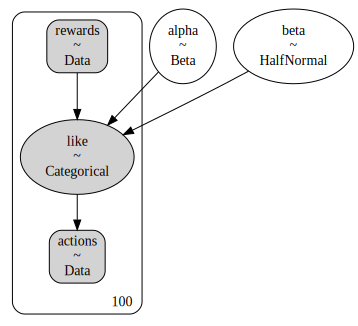

In [ ]:
pm.model_to_graphviz(bayesian_reinforcement_learning)

-----

# Summary Statistics Distribution

Now we simple use the estimates as independent samples to fit the distributions:

$$\alpha \sim \mathcal{beta}(a_{\alpha}, b_{\alpha}), \; \; \;  \beta \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta})$$


In [ ]:

true_alphas   = []
true_betas    = []
approx_alpha  = []
approx_beta   = []

for i in range(10):
  true_alphas.append(data['subject_'+str(i)]['true_alpha'])
  true_betas.append(data['subject_'+str(i)]['true_beta'])
  # approx_alpha.append(data['subject_'+str(i)]['trace']['alpha'])
  # approx_beta.append(data['subject_'+str(i)]['trace']['beta'])
  # means 
  approx_alpha.append(data['subject_'+str(i)]['trace']['alpha'].mean())
  approx_beta.append(data['subject_'+str(i)]['trace']['beta'].mean())


In [ ]:
trace['alpha'].std()

0.06007944915605776

In [ ]:
data['subject_'+str(i)]['trace']['alpha'].mean()

0.17771872426955176

In [ ]:
# https://stats.stackexchange.com/questions/68983/beta-distribution-fitting-in-scipy
a_al_true, b_al_true, loc_al_true, scale_al_true = stats.beta.fit(true_alphas, floc=0, fscale=1)
a_al_aprx, b_al_aprx, loc_al_aprx, scale_al_aprx = stats.beta.fit(approx_alpha, floc=0, fscale=1)

beta_true_mu, beta_true_std = stats.norm.fit(true_betas)
beta_aprx_mu, beta_aprx_std = stats.norm.fit(approx_beta)


In [ ]:
beta_true_mu, beta_true_std, beta_aprx_mu, beta_aprx_std

(3.108770229597089, 0.9595894475151323, 3.4020817685092277, 1.1838876850803135)

In [ ]:
for i, j in zip(['a', 'b', 'loc', 'scale'], [a_al_true, b_al_true, loc_al_true, scale_al_true]):
  print(i, ': ', str(round(j,2)))

print('-----')
for i, j in zip(['a', 'b', 'loc', 'scale'], [a_al_aprx, b_al_aprx, loc_al_aprx, scale_al_aprx]):
  print(i, ': ', str(round(j,2)))


a :  4.56
b :  10.27
loc :  0
scale :  1
-----
a :  2.09
b :  3.86
loc :  0
scale :  1


# Assess Fit: Summary Statistics Method

**COMPLETELY FAILED TO CONVERGE**

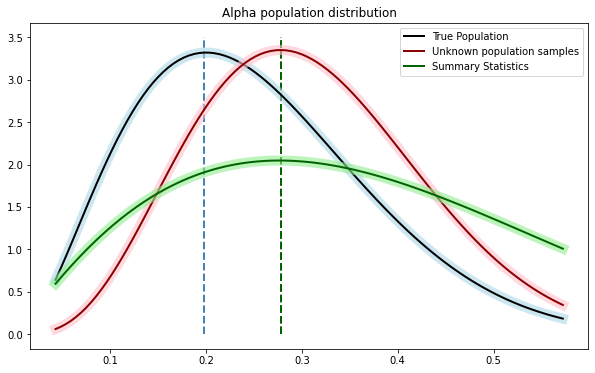

In [ ]:
# alpha population distribution ------------------------------*
# params
a,b = 3,9

# distribution
mean, var, skew, kurt = stats.beta.stats(a,b, moments='mvsk')
x = np.linspace(stats.beta.ppf(0.01, a, b),
                stats.beta.ppf(0.99, a, b), 100)
y = stats.beta.pdf(x, a, b)

# random sample
rv = stats.beta(a, b)
r  = rv.rvs(size=10000)

# vis 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'lightblue', lw=10, alpha=0.6)
ax.plot(x, y, 'k-', lw=2, label='True Population')
ax.vlines(x=x[np.where(y==max(y))], ymin=0, ymax=3.5, lw=2, color='steelblue', linestyles='dashed')

# fit (unknown) true sample values
rv_alpha_true = stats.beta(a=a_al_true, b=b_al_true, loc=loc_al_true, scale=scale_al_true).pdf(x)
ax.plot(x, rv_alpha_true, 'pink', lw=10, alpha=0.6)
ax.plot(x, rv_alpha_true, 'k-', lw=2, color='darkred', label='Unknown population samples')
ax.vlines(x=x[np.where(rv_alpha_true==max(rv_alpha_true))], ymin=0, ymax=3.5, lw=2, color='darkred', linestyles='dashed')

# fit approx values 
rv_alpha_aprx = stats.beta(a_al_aprx, b_al_aprx, loc_al_aprx, scale_al_aprx).pdf(x)
ax.plot(x, rv_alpha_aprx, 'lightgreen', lw=10, alpha=0.6)
ax.plot(x, rv_alpha_aprx, 'k-', lw=2, color='darkgreen', label='Summary Statistics')
ax.vlines(x=x[np.where(rv_alpha_aprx==max(rv_alpha_aprx))], ymin=0, ymax=3.5, lw=2, color='darkgreen', linestyles='dashed')


plt.title('Alpha population distribution')
plt.legend()
plt.show()
# alpha population distribution ------------------------------*

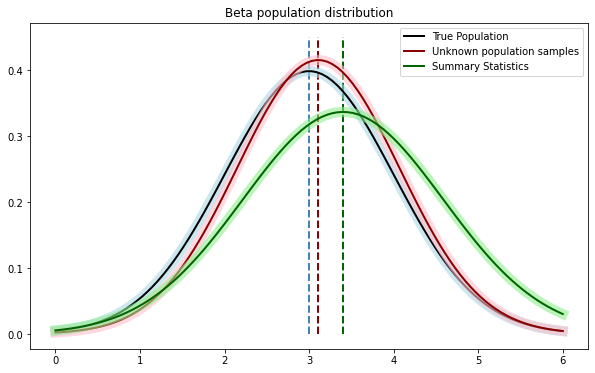

In [ ]:
# beta population distribution -------------------------------*
# params
mu        = 3
variance  = 1

# distribution
sigma = math.sqrt(variance)
x     = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y     = stats.norm.pdf(x, mu, sigma)

# random sample
# rv = stats.norm(mu, sigma)
# r  = rv.rvs(size=10000)

# vis 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'lightblue', lw=10, alpha=0.6)
ax.plot(x, y, 'k-', lw=2, label='True Population')
# ax.hist(r, bins=80, density=True, color='pink', histtype='stepfilled', alpha=0.4)
ax.vlines(x=mu, ymin=0, ymax=0.45, lw=2, color='steelblue', linestyles='dashed')


# fit (unknown) true sample values
rv_beta_true = stats.norm(beta_true_mu, beta_true_std).pdf(x)
ax.plot(x, rv_beta_true, 'pink', lw=10, alpha=0.6)
ax.plot(x, rv_beta_true, 'k-', lw=2, color='darkred', label='Unknown population samples')
ax.vlines(x=beta_true_mu, ymin=0, ymax=0.45, lw=2, color='darkred', linestyles='dashed')

# fit approx values 
rv_beta_apprx = stats.norm(beta_aprx_mu, beta_aprx_std).pdf(x)
ax.plot(x, rv_beta_apprx, 'lightgreen', lw=10, alpha=0.6)
ax.plot(x, rv_beta_apprx, 'k-', lw=2, color='darkgreen', label='Summary Statistics')
ax.vlines(x=beta_aprx_mu, ymin=0, ymax=0.45, lw=2, color='darkgreen', linestyles='dashed')

plt.title('Beta population distribution')
plt.legend()
plt.show()
# beta population distribution -------------------------------*

----

# Hierarchical Bayesian RL

Fitting an Hierarchical Bayesian RL model.


# Model

The model is the same as before, however now instead of setting a prior distribution over the parameters, a hyperprior is used to represent the population distribution.

-----

### Model 

Out $action \ space$ consists of $3$ options:

$$A:a\in\{c,s,n\}$$


### Data Generating Process

Arificially assume that:

$$\alpha = 0.4, \beta=7$$

We are absolute to simulated a dataset that captures this DGP.

Rewards are encoded in binary:

$$
r_t =
\begin{cases}
  & 1, \text{ if } a_t \text{ is correct } \\
  & 0, \text{ otherwise}
\end{cases}
$$


Initially we assume that the state values are stationary, with the probability of recieving a reward at each state being:

$$
Pr(r_t=1|Q_t(a)) = \begin{cases}
  & 0.8 \text{  if } a=c \\
  & 0.6 \text{  if } a=s \\
  & 0.7 \text{  if } a=n
\end{cases}
$$


***Given these parameters we can simulate choice behaviour.***

Initialize $t=0$ them all with equal probability:

$$Q_0(a)=\frac{1}{3} \ ∀ \ a\in \{c,s,n\}$$

Thereafter, the state space approximations are updated when an action is taken & feedback is recieved:

$$Q_t(a) = Q_{t-1}(a) + \alpha \left[ r_t - Q_{t-1}(a) \right]
$$



The state-space approximations are used to sample actions probabilistically in a multinomial fashion, following a Bolzmann distribution:


$$\pi_t(a) = \frac{exp \; \beta Q_t(a) }{ \sum_{a} 
exp \; \beta \ Q_t(a) 
}
$$


[reference](https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-hierarchical.html)

https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/multilevel_modeling.html

In [ ]:
# Convert to table data structure -------------*
%%time
if 'df' in globals(): del df

for subject in tqdm(data.keys()):
  if 'df' not in globals():
    df = pd.DataFrame({
        'subject' : [subject] * n_samples, 
        'actions' : data[subject]['actions'],
        'rewards' : data[subject]['rewards'],
        'true_alpha' : data[subject]['true_alpha'] * n_samples,
        'true_beta' : data[subject]['true_beta'] * n_samples
        })
  else:
    df2 = pd.DataFrame({
        'subject' : [subject] * n_samples, 
        'actions' : data[subject]['actions'],
        'rewards' : data[subject]['rewards'],
        'true_alpha' : data[subject]['true_alpha'] * n_samples,
        'true_beta' : data[subject]['true_beta'] * n_samples
        })
    df = df.append(df2, ignore_index=False)

df.shape

100%|██████████| 100/100 [00:00<00:00, 578.52it/s]

CPU times: user 173 ms, sys: 4.52 ms, total: 177 ms
Wall time: 179 ms


In [ ]:
df.head(3)

,subject,actions,rewards,true_alpha,true_beta,subjects
0,subject_0,1,0,50.360971,295.835581,0
1,subject_0,1,1,50.360971,295.835581,0
2,subject_0,2,0,50.360971,295.835581,0


In [ ]:

subject_idxs, subjects = pd.factorize(df.subject)
coords = {
    "subject": subjects,
    "sub_id" : np.arange(len(subject_idxs)),
}
coords


{'sub_id': array([   0,    1,    2, ..., 9997, 9998, 9999]),
 'subject': Index(['subject_0', 'subject_1', 'subject_2', 'subject_3', 'subject_4',
        'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9',
        'subject_10', 'subject_11', 'subject_12', 'subject_13', 'subject_14',
        'subject_15', 'subject_16', 'subject_17', 'subject_18', 'subject_19',
        'subject_20', 'subject_21', 'subject_22', 'subject_23', 'subject_24',
        'subject_25', 'subject_26', 'subject_27', 'subject_28', 'subject_29',
        'subject_30', 'subject_31', 'subject_32', 'subject_33', 'subject_34',
        'subject_35', 'subject_36', 'subject_37', 'subject_38', 'subject_39',
        'subject_40', 'subject_41', 'subject_42', 'subject_43', 'subject_44',
        'subject_45', 'subject_46', 'subject_47', 'subject_48', 'subject_49',
        'subject_50', 'subject_51', 'subject_52', 'subject_53', 'subject_54',
        'subject_55', 'subject_56', 'subject_57', 'subject_58', 'subject_59',
  

In [ ]:
%%time
# Bayes RL  ==================================================================================================================================*


with pm.Model(coords=coords) as hierarchical_bayes_RL:

  # Data
  subject_idx = pm.Data("subject_idx", subject_idxs, dims="sub_id")

  # data
  actions_  = pm.Data('actions', df.actions.values)
  rewards_  = pm.Data('rewards', df.rewards.values)


  # Hyperpriors
  a_alpha = pm.HalfNormal("a_alpha", 5.0)
  b_alpha = pm.HalfNormal("b_alpha", 5.0)
  mu_b    = pm.HalfNormal('mu_b',   10.0)
  sigma_b = pm.HalfNormal("sigma_b", 5.0)
 

  # Intercept for each county, distributed around group mean mu_a
  # Above we just set mu and sd to a fixed value while here we
  # plug in a common group distribution for all a and b (which are
  # vectors of length n_counties).

  # parameters
  alpha = pm.Beta('alpha', a_alpha,  b_alpha, dims="subject")
  beta = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="subject")


  # model 
  # init Qs
  Qs = 0.3333 * tt.ones((3, 100), dtype='float64')


  # Compute the Q values for each trial
  # Qs, _ = theano.scan(
  #     # fn=lambda action, reward, Qs, alpha: Qs[action],
  #     fn = lambda action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action])),
  #     sequences=[actions_[subject_idx], rewards_[subject_idx]],
  #     outputs_info=[Qs],
  #     non_sequences=[alpha]
  # )
  Qs, _ = theano.scan(
      # fn=lambda action, reward, Qs, alpha: Qs[action],
      fn = lambda action, reward, alpha, Qs: tt.set_subtensor(Qs[0,0], Qs[0,0]),
      sequences=[df2.actions, df2.rewards, alpha[subject_idx]],
      outputs_info=[Qs]
  )

  


  BQs = beta[subject_idx]  * Qs[:, subject_idx]
  pi =  tt.nnet.softmax(BQs)
  like = pm.Categorical('P[A]', p=pi, observed=actions_, dims='sub_id')

    # opt
  # trace = pm.sample(tune=1000, chains=2, target_accept=0.85) # tune=5000, target_accept=0.9 njobs=4 ,target_accept=0.99
  # idata = az.from_pymc3(trace)
  # pm.traceplot(idata)

pm.model_to_graphviz(hierarchical_bayes_RL)
  # Bayes RL  ==================================================================================================================================*

TypeError: ignored

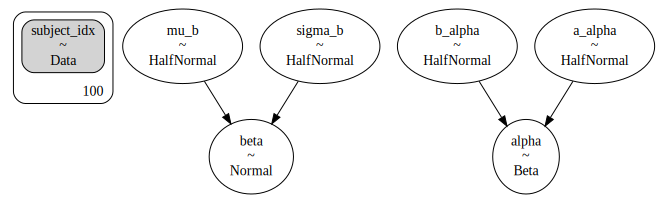

In [ ]:
# ?theano.scan
pm.model_to_graphviz(hierarchical_bayes_RL)

# Ficticious example

In [ ]:
df_data = pd.DataFrame(columns=["date"]).set_index("date")
dates = pd.date_range(start="2020-05-01", end="2020-05-20")

for city, mu in {"Berlin": 15, "San Marino": 18, "Paris": 16}.items():
    df_data[city] = np.random.normal(loc=mu, size=len(dates))

df_data.index = dates
df_data.index.name = "date"
df_data.head()

,Berlin,San Marino,Paris
date,,,
2020-05-01,14.519212,17.504966,16.545445
2020-05-02,15.931921,17.049598,17.271231
2020-05-03,14.824480,17.882649,17.340459
2020-05-04,14.797922,17.750652,14.783640
2020-05-05,15.252943,17.112405,15.617392


# Simpler case: 1 subject

In [ ]:
df2.head(2)

,subject,actions,rewards,true_alpha,true_beta
0,subject_99,0,1,22.152091,299.777837
1,subject_99,0,1,22.152091,299.777837


In [ ]:
# REGULAR RL MODEL WITH COORDS ------------XXXXXX


subject_idxs, subjects = pd.factorize(df2.subject)
coords = {
    "subject": subjects,
    "sub_id" : np.arange(len(subject_idxs)),
}
coords

{'sub_id': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 'subject': Index(['subject_99'], dtype='object')}

In [ ]:
with pm.Model(coords=coords) as dummy_model:
  subject_idx = pm.Data("subject_idx", subject_idxs, dims="sub_id")

  # hyperpriors
  mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
  sigma_a = pm.HalfNormal("sigma_a", 5.0)
  mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
  sigma_b = pm.HalfNormal("sigma_b", 5.0)

  a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="subject")
  b = pm.Normal("b", mu=mu_b, sigma=sigma_b, dims="subject")

  eps = pm.HalfCauchy("eps", 5.0)
  radon_est = a[subject_idx] + b[subject_idx] * df.true_beta.values

    # Data likelihood
  radon_like = pm.Normal(
        "radon_like", mu=radon_est, sigma=eps, observed=df.true_alpha, dims="sub_id"
    )

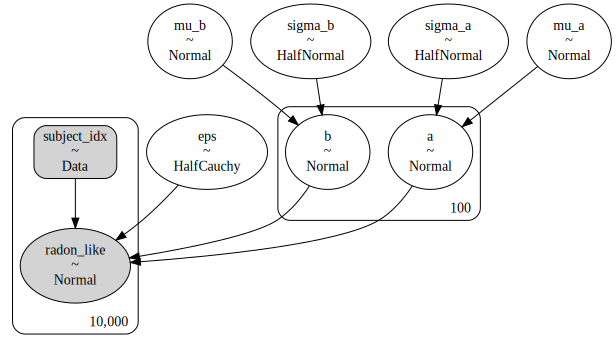

In [ ]:
pm.model_to_graphviz(dummy_model)


# Heirarchical Bayes RL

In [ ]:
coords['sub_id']

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
Qs = 0.3333 * tt.ones((3,100), dtype='float64')
Qs = tt.set_subtensor(Qs[0,0], 1)
Qs.shape.eval()

array([  3, 100])

In [ ]:
# REGULAR RL MODEL WITH COORDS ------------XXXXXX


subject_idxs, subjects = pd.factorize(df2.subject)
coords = {
    "subject": subjects,
    "sub_id" : np.arange(len(subject_idxs)),
}
coords

{'sub_id': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 'subject': Index(['subject_99'], dtype='object')}

In [ ]:
data = pd.DataFrame({'idx': subject_idxs, 'actions':df2.actions, 'rewards':df2.rewards})

data

,idx,actions,rewards
0,0,0,1
1,0,0,1
2,0,2,1
3,0,2,1
4,0,0,1
...,...,...,...
95,0,1,0
96,0,0,1
97,0,2,1
98,0,2,0


In [ ]:
def fetch_data(idx):
  sub = data.loc[data.idx==idx,]
  act = sub.actions.values
  rew = sub.rewards.values
  return act, rew


def tensor_update(idx, alpha, Qs):
  action, reward = fetch_data(idx)
  print('okay!')
  Qs = tt.set_subtensor(Qs[idx, action], Qs[idx, action] + alpha * (reward - Qs[idx, action]))
  return Qs

In [ ]:
with pm.Model(coords=coords) as hierarchical_bayes_RL:
  subject_idx = pm.Data("subject_idx", subject_idxs, dims="sub_id")

    # data
  # actions_  = pm.Data('actions',  data.actions.values)
  # rewards_  = pm.Data('rewards',  data.rewards.values)
  # idx_      = pm.Data('idx',      data.idx.values)

  # Hyperpriors
  a_alpha = pm.HalfNormal("a_alpha", 5.0)
  b_alpha = pm.HalfNormal("b_alpha", 5.0)
  mu_b    = pm.HalfNormal('mu_b',   10.0)
  sigma_b = pm.HalfNormal("sigma_b", 5.0)
 


  # parameters
  alpha = pm.Beta('alpha', a_alpha,  b_alpha, dims="subject")
  beta = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="subject")

  
  # Q matrix
  Qs = 0.3333 * tt.ones((100,3), dtype='float64')

  # UPDATE Qs
  # for each subject
    # for each action
  # Qs, _ = theano.scan( # idx?????????????
  #       fn = lambda action, reward, alpha, idx, Qs: tt.set_subtensor(Qs[action, idx], Qs[action, idx] + alpha * (reward - Qs[action, idx])),
  #       sequences = [df2.actions, df2.rewards, alpha[subject_idx], subject_idx],
  #       # outputs_info = [Qs]
  #   )


  # for ix in data.idx.unique():
  #   print(ix)
  #   sub = data.loc[data.idx==ix,]
  #   act = sub.actions.values
  #   rew = sub.rewards.values
  #   Qs, _ = theano.scan( # idx?????????????
  #         fn = lambda action, reward, alpha, idx, Qs: tt.set_subtensor(Qs[action, idx], Qs[action, idx] + alpha * (reward - Qs[action, idx])),
  #         sequences = [act, rew, alpha],
  #         # outputs_info = [Qs]
  #     )

 
    # Qs, _ = theano.scan(
    #   fn  = lambda alpha, idx, Qs: tt.set_subtensor(Qs[0,0], 999),
    #   sequences = [alpha, subject_idx], # , df2.actions, df2.rewards
    #     outputs_info=[Qs],

    # )




  Qs, _ = theano.scan(
      fn  = lambda idx, alpha, Qs: tensor_update,
      sequences = [subject_idx, alpha], # , df2.actions, df2.rewards
       outputs_info=[Qs]
  )




  # Qs, _ = theano.scan(
  #     fn  = lambda alpha, idx, Qs: tt.set_subtensor(Qs[idx,0], 999),
  #     sequences = [alpha, subject_idx], # , df2.actions, df2.rewards
  #      outputs_info=[Qs],

  # )
 

  # apply softmax -------------------------* 
  BQs = beta * Qs
  BQs, _ = theano.scan(
      fn  = lambda b, q: tt.nnet.softmax(b*q),
      sequences = [beta, Qs]
  )

  # pi  = tt.nnet.softmax(BQs)
  pi  = BQs[subject_idx]
  PA  = pm.Categorical('P[A]', p=pi, observed=df2.actions, dims='sub_id')



pm.model_to_graphviz(hierarchical_bayes_RL)
  # Bayes RL  ==================================

ValueError: ignored

In [ ]:
Qs

MissingInputError: ignored

# Pyro π

In [ ]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random

assert numpyro.__version__.startswith("0.8.0")

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
data

,idx,actions,rewards
0,0,0,1
1,0,0,1
2,0,2,1
3,0,2,1
4,0,0,1
...,...,...,...
95,0,1,0
96,0,0,1
97,0,2,1
98,0,2,0


In [ ]:
# from scipy.special import softmax
data

,idx,actions,rewards
0,0,0,1
1,0,0,1
2,0,2,1
3,0,2,1
4,0,0,1
...,...,...,...
95,0,1,0
96,0,0,1
97,0,2,1
98,0,2,0


In [ ]:
# artificial probs
pi = np.random.rand(*data.shape)
pi.shape

(100, 3)

In [ ]:
def model(data, actions=None):

  # Hyperpriors
  a_α = numpyro.sample("a_α", dist.HalfNormal(5.0))
  b_α = numpyro.sample("b_α", dist.HalfNormal(5.0))
  μ_β = numpyro.sample("μ_β", dist.HalfNormal(10.0))
  σ_β = numpyro.sample("σ_β", dist.HalfNormal(5.0))

  
  # Q matrix
  Qs = 0.3333 * np.ones((1,3), dtype='float64')


  subject_idx         = data.idx
  unique_subject_IDs  = np.unique(subject_idx)
  n_subjects          = len(unique_subject_IDs)


  # parameters
  with numpyro.plate("i", n_subjects):
    α = numpyro.sample("α", dist.Beta(a_α, b_α))
    β = numpyro.sample("β", dist.Normal(μ_β, σ_β))


  # Q update
  for idx in unique_subject_IDs:
    sub = data.loc[data.idx==idx,]
    at = sub.actions.values
    rt = sub.rewards.values
    Qs[idx, at] = Qs[idx, at] + (rt - Qs[idx, at])


  # model 
  BQs = (β*Qs)[subject_idx]

  with numpyro.plate("data", len(subject_idx)):
    # z = β*Qs

    # artificial probabilitites
    pi = np.random.rand(*data.shape)
    numpyro.sample("obs", dist.Categorical(probs=pi), obs=actions)



  # Add:
  # - softmax               choice probabilisties
  # - dist.Categorical()    sample yhat
  # - loop through alpha    update Q


numpyro.render_model(model, model_args=(data, None))

ValueError: ignored

In [ ]:
# ?numpyro.render_model#(modelsubject_idx, data)

# import pyro



In [ ]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, subject_idx, data, actions=None)

posterior_samples = mcmc.get_samples()

In [ ]:
?dist.CategoricalProbs

In [ ]:
FVC_obs = train["FVC"].values
Weeks = train["Weeks"].values
PatientID = train["PatientID"].values

In [ ]:
def model(PatientID, Weeks, FVC_obs=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 100.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 100.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(100.0))

    np.unique()
    unique_patient_IDs = np.unique(PatientID)
    n_patients = len(unique_patient_IDs)

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[PatientID] + β[PatientID] * Weeks

    with numpyro.plate("data", len(PatientID)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)

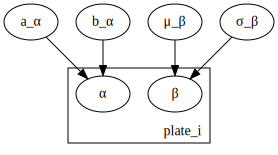

array([ 0,  0,  0, ..., 99, 99, 99])

In [ ]:
n_subjects

100

In [ ]:
import pystan

data_dict = {'n_s': n_subjects, 'n_t': n_subjects*100, 'Action': actions, 'Reward':rewards, 'Subjects':subject}


# πStan

In [ ]:
import pystan
# https://mc-stan.org/users/documentation/case-studies/radon.html

In [ ]:
subjects    = df.subject.unique()
n_subjects  = len(subjects)
sub_lookup  = dict(zip(subjects, range(len(subjects))))
subjects    = df['subjects'] = df.subject.replace(sub_lookup).values
actions     = df.actions.values
rewards     = df.rewards.values


In [ ]:
df2.head(3)

,subject,actions,rewards,true_alpha,true_beta
0,subject_99,2,1,28.265336,301.148257
1,subject_99,2,1,28.265336,301.148257
2,subject_99,2,1,28.265336,301.148257


In [ ]:
df2.actions + 1

0     2
1     2
2     2
3     2
4     2
     ..
95    1
96    1
97    1
98    1
99    0
Name: actions, Length: 100, dtype: int64

In [ ]:
# assume Q is knowndf2
a = 28.265336
b = 
df2

,subject,actions,rewards,true_alpha,true_beta
0,subject_99,2,1,28.265336,301.148257
1,subject_99,2,1,28.265336,301.148257
2,subject_99,2,1,28.265336,301.148257
3,subject_99,2,1,28.265336,301.148257
4,subject_99,2,1,28.265336,301.148257
...,...,...,...,...,...
95,subject_99,1,1,28.265336,301.148257
96,subject_99,1,1,28.265336,301.148257
97,subject_99,1,0,28.265336,301.148257
98,subject_99,1,1,28.265336,301.148257


In [ ]:
# 1 subject ---------------------------------------------------*
stan_data = {
    'n_t':len(df2.actions),
    'actions':df2.actions + 1,
    'rewards':df2.rewards}



stan_model = """
data {
  int<lower=0>  n_t;
  vector[n_t]   actions;
  vector[n_t]   rewards;
}

parameter {
  real<lower=0,upper=1> alpha;
  real beta;
}

model {
  vector[3] Qs;
  vector[3] BQs;
  vector[3] pi;

  for (t in 1:n_t) {

    if (t == 1){
      for (v in 1:4){
        Qs[v] = 0.3333
      }
    }

    // update Qs ----------*
    Qs[actions[t]] = Qs[actions[t]] - alpha * (rewards[t] - Qs[actions[t]])

    BQs = beta * Qs
    BQs = Qs
    //denom = exp(BQs[1]) + exp(BQs[2]) + exp(BQs[3])
    //for (v in 1:4){
     //pi[v] = exp(BQs[v])/ denom
    //}
    


    // sample from categorgical ---------*
    actions[t] ~ CategoricalLogit(BQs);
  }
}

"""

fit = pystan.stan(model_code=stan_model, data=stan_data, iter=1000, chains=2)
print(fit)
fit.plot()

ValueError: ignored